# Ground-state structure optimization

Molecular structure optimizations always start from an initial guess of the molecular geometry (constructed using [SMILES](), a chemistry software, e.g. [Avogadro](), or downloaded from a [database]()). In the following, we will see how to perform ground-state geometry optimization using [VeloxChem](https://veloxchem.org/) and [GeomeTRIC](https://github.com/leeping/geomeTRIC).

## SCF geometry optimization

In [ ]:
import veloxchem as vlx
import py3Dmol as p3d
from matplotlib import pyplot as plt
import numpy as np
import geometric
import sys
ostream = vlx.OutputStream(sys.stdout)

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [ ]:
# Set up the molecule and basis set
water_xyz = """3
water molecule, bond angle 150 deg
O       0.0000000       0.0000000       0.0000000
H       0.2760264       0.8822741       0.6495351
H       0.1036576      -0.7768012      -0.5501827
"""

basis_set_label = 'sto-3g'
molecule = vlx.Molecule.from_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, basis_set_label)

* Info * Reading basis set from file: /home/emi/miniconda3/envs/echem/lib/python3.10/site-packages/veloxchem/basis/STO-3G 
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: STO-3G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [1]:
# View initial structure of the molecule
view = p3d.view(viewergrid=(1,1),width=300, height=300)
view.addModel(water_xyz, 'xyz', viewer=(0,0))
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({'stick': {}, 'sphere': {'scale':0.25}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# Run the initial SCF and set up the gradient and optimization drivers
scf_drv = vlx.ScfRestrictedDriver()
# Settings for DFT:
# scf_drv.xcfun = "b3lyp"
scf_results = scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

```python
# Set up the gradient and optimization dirvers:
grad_drv = vlx.ScfGradientDriver(scf_drv)
opt_drv = vlx.OptimizationDriver(grad_drv)

opt_drv.filename = "../../data/structopt/h2o_gsstructopt"
# Run the optimization
opt_molecule = opt_drv.compute(molecule, basis)
```

Let's plot the energies calculated during the optimization and check how the structure changes.

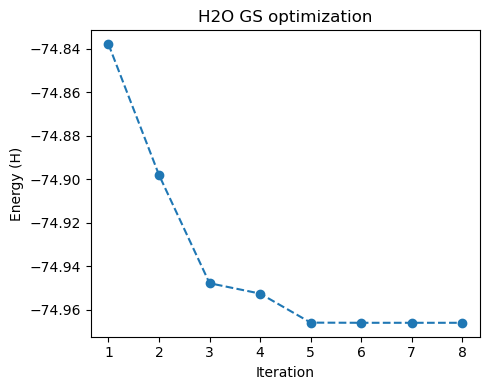

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# The data we need are stored in the output file generated during the geometry optimization.
# Let's write a routine which reads these data points from file.
def read_optimization_file(file_name):
    output_file = open(file_name, "r")
    structures = output_file.read()
    output_file.close()
    output_file = open(file_name, "r")
    steps = []
    energies = []
    i = 1
    for line in output_file:
        if 'Energy' in line:
            parts = line.split()
            if parts:
                energy = float(parts[-1])
                energies.append(energy)
                steps.append(i)
                i += 1
    output_file.close()
    return steps, energies, structures

steps, energies, structures = read_optimization_file('../../data/structopt/h2o_gsstructopt_optim.xyz')


# Plot the energies
plt.figure(figsize=(5,4))
plt.plot(steps, energies,'o--')
plt.xlabel('Iteration')
plt.ylabel('Energy (H)')
plt.title("H2O GS optimization")
plt.tight_layout(); plt.show()

# Animate optimization
viewer = p3d.view(width=300, height=200)
viewer.addModelsAsFrames(structures)
viewer.animate({"loop": "forward"})
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({'stick': {}, 'sphere': {'scale':0.25}})
# # rotate for a better initial view
# viewer.rotate(-90, "y")
# viewer.rotate(-90, "x")
viewer.show()

### Internal coordinate scan

Let's say that we want to see how the total energy varies when we change one internal coordinate and we optimize the rest. For this, we can set up a scan using [geomeTRIC](https://github.com/leeping/geomeTRIC)

```python
# Set up the gradient and optimization dirvers:
grad_drv = vlx.ScfGradientDriver(scf_drv)
opt_drv = vlx.OptimizationDriver(grad_drv)

opt_drv.filename = "../../data/structopt/h2o_scan"
angle_scan = "angle 2 1 3 70 140.0 20" 
opt_drv.constraints = ["$scan", angle_scan]

# Run the scan
opt_molecule = opt_drv.compute(molecule, basis)
```

In [6]:
angle_scan = "angle 2 1 3 70 140.0 20" 

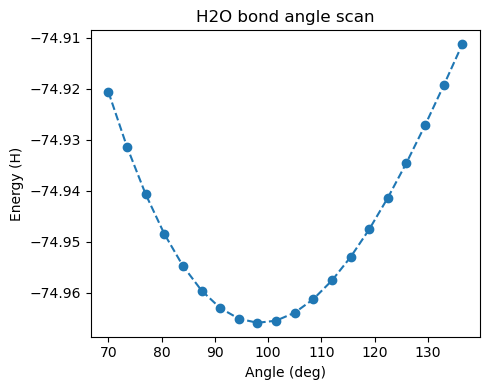

In [7]:
def read_scan(file_name, natms, constraint):
    # start, stop and how many steps
    parts = constraint.split()
    start = float(parts[-3])
    stop = float(parts[-2])
    no_steps = int(parts[-1])
    step = (stop - start) / no_steps
    
    scan_coords = []
    energies = []
    structures = []
    
    for i in range(no_steps):
        energy = 500
        if i+1 < 10:
            output_name = file_name + "_scan-00%d.xyz" % (i+1)
        elif i+1 < 100:
            output_name = file_name + "_scan-0%d.xyz" % (i+1)
        else:
            output_name = file_name + "_scan-%d.xyz" % (i+1)
        output_file = open(output_name, "r")
    
        # The optimized geometry is the last geometry in the file
        # in xyz format.
        nlines = natms + 2
        lines = output_file.readlines()
    
        opt_struct = ""
    
        for line in lines[-nlines:]:
            opt_struct += line
            if "Energy" in line:
                parts = line.split()
                energy = float(parts[-1])
        scan_coords.append(start + i*step)
        energies.append(energy)
        structures.append(opt_struct)

    return scan_coords, energies, structures

natms = molecule.number_of_atoms()
scan_coords, energies, structures = read_scan("../../data/structopt/h2o_scan", natms, angle_scan)


# Plot the energies
plt.figure(figsize=(5,4))
plt.plot(scan_coords, energies,'o--')
plt.xlabel('Angle (deg)')
plt.ylabel('Energy (H)')
plt.title("H2O bond angle scan")
plt.tight_layout(); plt.show()

### Constrained optimization

Now let's see how to run a constrained optimization. For this example, we will constrain the OH bond lengths to specific values and we will optimize the bond angle of the water molecule to construct a "relaxed" potential energy surface. For this, we will need several water structures with different combinations of OH bond lengths. These will be read from file.

In [8]:
# Since we are considering many combinations, running this cell may take a while...
bond_lengths = np.arange(0.8, 1.9, 0.1)
folder = "../../data/structopt/h2o_relaxed_pes/"

```python
i = 0
for r1 in bond_lengths:
    # We will constrain the first OH bond length to bond_1.
    bond_1 = "distance 1 2 %.2f" % r1 
    for r2 in bond_lengths[i:]:
        file_name = folder + "h2o_%.2f_%.2f" % (r1, r2)
        file = open(file_name + ".xyz" , "r")
        h2o_xyz = file.read()
        file.close()
        new_molecule = vlx.Molecule.from_xyz_string(h2o_xyz)
        scf_results = scf_drv.compute(new_molecule, basis)
        
        # Set up the gradient and optimization dirvers:
        new_grad_drv = vlx.ScfGradientDriver(scf_drv)
        new_opt_drv = vlx.OptimizationDriver(new_grad_drv)
        new_opt_drv.filename = file_name
        
        # We will constrain the second OH bond length to value bond_2.
        bond_2 = "distance 1 3 %.2f" % r2
        
        # Possible options: set, scan, freeze.
        new_opt_drv.constraints = ["$set", bond_1, bond_2]
        
        # We now optimize th bond angle:
        h2o_opt = new_opt_drv.compute(new_molecule, basis)
    i += 1
```

In [9]:
def read_optimized_structure(file_name, natms):
    output_file = open(file_name, "r")
    
    # The optimized geometry is the last geometry in the file
    # in xyz format.
    nlines = natms + 2
    lines = output_file.readlines()
    
    opt_struct = ""
    
    for line in lines[-nlines:]:
        opt_struct += line
        if "Energy" in line:
            parts = line.split()
            energy = float(parts[-1])
    
    output_file.close()
    
    return energy, opt_struct

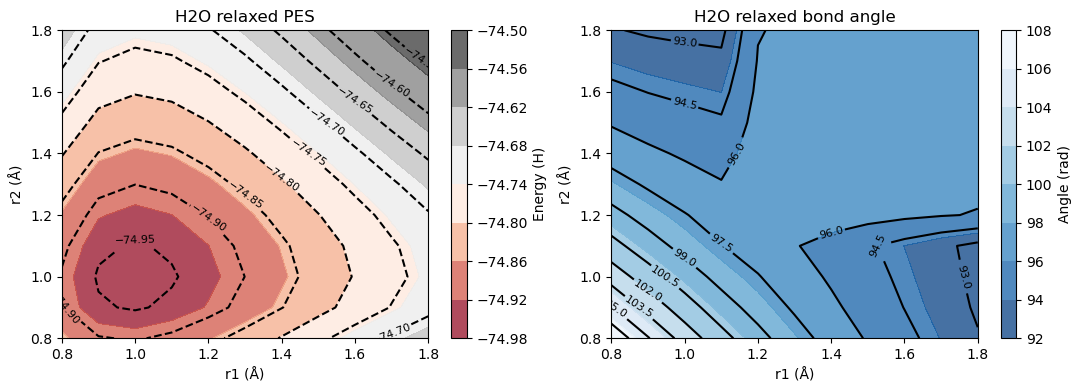

In [10]:
# Now let's plot the 2D PES and the 2D map of relaxed bond angles.
npts = bond_lengths.shape[0]

natm = molecule.number_of_atoms()

pes = np.zeros((npts, npts))
theta = np.zeros((npts, npts))

# Read energies
i = 0
for r1 in bond_lengths:
    j = i
    for r2 in bond_lengths[i:]:
        file_name = folder + "h2o_%.2f_%.2f_optim.xyz" % (r1, r2)
        energy, xyz_opt = read_optimized_structure(file_name, natm)
        pes[i,j] = energy
        pes[j,i] = energy
        
        # calculate the relaxed bond angle
        opt_molecule = vlx.Molecule.from_xyz_string(xyz_opt)
        angle = geometric.internal.Angle(1, 0, 2)
        coords = opt_molecule.get_coordinates().reshape((3 * natm))
        # transform from radians to degrees
        angle_value = (angle.value(coords))*180.0/np.pi
        theta[i,j] = angle_value
        theta[j,i] = angle_value
        
        j += 1
    i += 1


fig = plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
plt.xlabel('r1 (Å)')
plt.ylabel('r2 (Å)')
plt.title("H2O relaxed PES")
conts = plt.contour(bond_lengths, bond_lengths, pes, 10, colors='black')
plt.clabel(conts, inline=True, fontsize=8)
CS=plt.contourf(bond_lengths, bond_lengths, pes, cmap="RdGy",
                alpha=0.75)
cbar=plt.colorbar(CS)
cbar.set_label("Energy (H)")


plt.subplot(1, 2, 2)
plt.xlabel('r1 (Å)')
plt.ylabel('r2 (Å)')
plt.title("H2O relaxed bond angle")
conts = plt.contour(bond_lengths, bond_lengths, theta, 10, colors='black')
plt.clabel(conts, inline=True, fontsize=8)
CS = plt.contourf(bond_lengths, bond_lengths, theta,
                  cmap="Blues_r", alpha=0.75)
cbar=plt.colorbar(CS)
cbar.set_label("Angle (rad)")
plt.show()

## XTB geometry optimization

In the following we will perform a ground state structure optimization of cafestol and kahweol. Cafestol is a molecule present in Robusta coffee beans, while kahweol is a very similar molecule present in Arabica coffee beans. Kahweol has a distinctive Raman peak which allows to identify Arabica coffee beans by Raman spectroscopy. Here, we determine the relaxed geometries of these two molecules. Since these molecules are large, we will use the semiempirical tight binding method from the [Xtb code](https://xtb-docs.readthedocs.io/en/latest/contents.html). Veloxchem has dedicated drivers which connect to Xtb.

In [11]:
cafestol_xyz = """51
cafestol initial structure
O  -4.5215   -1.3455    0.4926
O  -5.2905    0.0812   -1.7033
O   5.1630    0.4345   -0.1101
C  -1.2807   -0.7511   -0.0465
C  -0.5244    0.5810   -0.4102
C   0.9909    0.6610    0.0407
C  -2.9440    0.2916    1.2866
C  -1.8143   -0.7311    1.3945
C  -2.6188   -0.8159   -0.8642
C  -3.7116   -0.2387    0.0606
C  -0.4332   -2.0024   -0.3283
C  -1.3742    1.8303   -0.0654
C   1.6844   -0.6873   -0.4019
C  -2.3206    1.6833    1.1309
C   0.9997   -1.9155    0.1913
C   1.7285    1.8344   -0.7277
C   1.1437    0.9261    1.5588
C   3.1644   -0.6155   -0.2085
C  -4.6490    0.7442   -0.6282
C   3.2525    1.9378   -0.4590
C   3.8298    0.5879   -0.2856
C   4.1654   -1.5888    0.0140
C   5.3604   -0.9015    0.0689
H  -0.4604    0.5817   -1.5108
H  -3.5646    0.2626    2.1897
H  -1.0861   -0.4449    2.1498
H  -2.1902   -1.7145    1.7003
H  -2.5286   -0.2495   -1.7981
H  -2.8534   -1.8505   -1.1460
H  -0.3943   -2.1694   -1.4136
H  -0.9135   -2.8938    0.0946
H  -1.9810    2.0650   -0.9487
H  -0.7587    2.7222    0.0818
H   1.5605   -0.7646   -1.4951
H  -1.7642    1.9154    2.0477
H  -3.1082    2.4431    1.0635
H   1.0176   -1.9046    1.2859
H   1.5276   -2.8282   -0.1118
H   1.2808    2.8061   -0.4944
H   1.5851    1.6842   -1.8068
H   0.5898    1.8173    1.8670
H   0.8147    0.0892    2.1727
H   2.1832    1.0992    1.8532
H  -4.1337    1.6158   -1.0351
H  -5.4265    1.0934    0.0595
H   3.4273    2.5264    0.4487
H   3.7385    2.4646   -1.2871
H  -3.9519   -2.0832    0.7635
H   4.0442   -2.6573    0.1180
H  -5.7603   -0.6874   -1.3370
H   6.3869   -1.2031    0.2186
"""
cafestol = vlx.Molecule.from_xyz_string(cafestol_xyz)

In [12]:
kahweol_xyz = """49
kahweol initial structure
O  -4.4710   -1.5361    0.0905
O  -5.6188    0.9753   -0.0811
O   5.1625    0.5695   -0.0997
C  -1.2209   -0.8317   -0.2017
C  -0.4821    0.5357   -0.4703
C  -3.0038    0.1167    1.0462
C  -1.8514   -0.8737    1.1997
C  -2.4967   -0.9058   -1.1119
C   0.9884    0.6333    0.0944
C  -3.6676   -0.3924   -0.2474
C  -0.3220   -2.0551   -0.4569
C  -1.3919    1.7479   -0.1363
C  -2.4167    1.5304    0.9816
C   1.7435   -0.6786   -0.3542
C   1.0741   -1.9483    0.1552
C   1.0367    0.8330    1.6293
C  -4.5845    0.5870   -0.9677
C   1.7610    1.8511   -0.4907
C   3.2146   -0.5444   -0.1101
C   3.1013    1.8722   -0.6493
C   3.8167    0.6946   -0.3059
C   4.2309   -1.4546    0.2464
C   5.3980   -0.7259    0.2399
H  -0.3415    0.5842   -1.5631
H  -3.6779    0.0397    1.9072
H  -1.1861   -0.6021    2.0159
H  -2.2356   -1.8757    1.4322
H  -2.3648   -0.3090   -2.0216
H  -2.6844   -1.9384   -1.4328
H  -0.2098   -2.1924   -1.5413
H  -0.8043   -2.9694   -0.0890
H  -1.9406    2.0033   -1.0514
H  -0.8134    2.6482    0.0921
H  -1.9341    1.7452    1.9434
H  -3.2193    2.2709    0.8849
H   1.6699   -0.7251   -1.4553
H   1.0259   -1.9792    1.2481
H   1.6508   -2.8307   -0.1490
H   2.0514    1.0518    1.9842
H   0.4166    1.6762    1.9486
H   0.7233   -0.0489    2.1864
H  -5.0524    0.1195   -1.8415
H  -4.0679    1.4861   -1.3088
H   1.2088    2.7568   -0.7218
H  -5.0925   -1.2746    0.7905
H   3.6240    2.7536   -0.9997
H   4.1386   -2.5085    0.4650
H  -6.2132    0.2149    0.0339
H   6.4308   -0.9731    0.4374
"""
kahweol = vlx.Molecule.from_xyz_string(kahweol_xyz)

The difference between cafestol and kahweol is very subtle, essentially only one double bond and two H atoms.

In [13]:
print("\n               (a) Cafestol                                 (b) Kahweol")
viewer = p3d.view(viewergrid=(1,2),width=700,height=250, linked=True)
viewer.addModel(cafestol_xyz, 'xyz', viewer=(0,0))
viewer.addModel(kahweol_xyz, 'xyz', viewer=(0,1))
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({'stick': {}, 'sphere': {'scale':0.25}})
viewer.zoomTo()
viewer.show()


               (a) Cafestol                                 (b) Kahweol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
# Set up the xtb driver
method_settings = {'xtb':'gfn2'}
xtbdrv = vlx.XtbDriver()
xtbdrv.set_method(method_settings['xtb'].lower())
xtbdrv.compute(cafestol, ostream)

                                                                                                                          
                                                        XTB Driver                                                        
                                                                                                                          

* Info *   Energy   : -69.3615122026 a.u.                                                                                 
* Info *   Gradient : 8.325170e-03 a.u. (RMS)                                                                             
* Info *              1.928275e-02 a.u. (Max)                                                                             
* Info *   Time     : 0.34 sec                                                                                            
                                                                                                                          
* Info * Refere

### Set up the xtb gradient and optimization drivers and run the geometry optimization

In [15]:
xtb_grad_drv = vlx.XtbGradientDriver(xtbdrv)
xtb_opt_drv = vlx.OptimizationDriver(xtb_grad_drv)
xtb_opt_cafestol = xtb_opt_drv.compute(molecule)

                                                                                                                          
                                                Optimization Driver Setup                                                 
                                                                                                                          
                                     Coordinate System       :    TRIC                                                    
                                     Constraints             :    No                                                      
                                     Max. Number of Steps    :    300                                                     
                                     Transition State        :    No                                                      
                                     Hessian                 :    never                                                   
                

### Run the XTB structure optimization for kahweol:

In [16]:
xtbdrv = vlx.XtbDriver()
xtbdrv.set_method(method_settings['xtb'].lower())
xtbdrv.compute(kahweol, ostream)
xtb_grad_drv = vlx.XtbGradientDriver(xtbdrv)
xtb_opt_drv = vlx.OptimizationDriver(xtb_grad_drv)
xtb_opt_kahweol = xtb_opt_drv.compute(kahweol)

                                                                                                                          
                                                        XTB Driver                                                        
                                                                                                                          

          ...................................................
* Info *   Energy   : -68.3102341570 a.u.                                                                                 
* Info *   Gradient : 8.430853e-03 a.u. (RMS)                                                                             
* Info *              3.152908e-02 a.u. (Max)                                                                             
* Info *   Time     : 0.36 sec                                                                                            
                                                                            

### Compare initial and final geometries

In [17]:
def xyz(molecule):
    """
    Returns the molecular geometry in xyz format.
    """
    from veloxchem.veloxchemlib import ChemicalElement
    from veloxchem.veloxchemlib import bohr_in_angstroms

    elem_ids = molecule.elem_ids_to_numpy()

    xs = molecule.x_to_numpy() * bohr_in_angstroms()
    ys = molecule.y_to_numpy() * bohr_in_angstroms()
    zs = molecule.z_to_numpy() * bohr_in_angstroms()

    txt = "" 
    txt +="%d\n\n" % molecule.number_of_atoms()
    for elem_id, x, y, z in zip(elem_ids, xs, ys, zs):
        elem = ChemicalElement()
        elem.set_atom_type(elem_id)
        txt += "%6s %22.12f %22.12f %22.12f\n" % (elem.get_name(),x,y,z)
        
    return txt

In [18]:
# xtb_opt_cafestol.write_xyz("xtb_opt_cafestol.xyz")
# xtb_opt_kahweol.write_xyz("xtb_opt_kahweol.xyz")
# 
xyz_xtb_opt_cafestol = open("../../data/structopt/xtb_opt_cafestol.xyz", "r").read() # read optimized geometry from file
xyz_xtb_opt_kahweol = open("../../data/structopt/xtb_opt_kahweol.xyz", "r").read()

print('\n (a) Cafestol, initial vs. XTB opt. geom.         (b) Kahweol, initial vs. XTB opt. geom.:')
viewer = p3d.view(viewergrid=(1,2),width=700,height=250, linked=True)
viewer.addModel(cafestol_xyz, 'xyz', viewer=(0,0))
viewer.addModel(xyz_xtb_opt_cafestol, 'xyz', viewer=(0,0))
viewer.addModel(kahweol_xyz, 'xyz', viewer=(0,1))
viewer.addModel(xyz_xtb_opt_kahweol, 'xyz', viewer=(0,1))
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({'stick': {}, 'sphere': {'scale':0.25}})
viewer.zoomTo()
viewer.show()


 (a) Cafestol, initial vs. XTB opt. geom.         (b) Kahweol, initial vs. XTB opt. geom.:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol